In [1]:

import sys
 
# setting path
sys.path.append('../../')

from pandas import read_csv, to_datetime, DataFrame
import pyfolio as pf
from API_test import get_portfolio_history
from datetime import datetime
from numpy import nan

/Users/yueyuchen/opt/anaconda3/envs/RL/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
YmdHMS_format = "%Y-%m-%d-%H-%M-%S"
Ymd_format = "%Y-%m-%d"
S_format = "%f"


<AxesSubplot:xlabel='Datetime'>

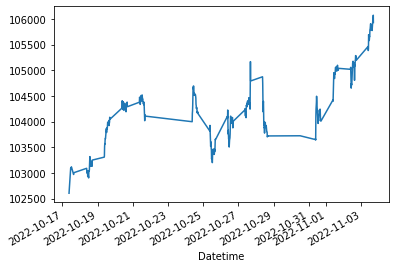

In [4]:
since = '2022-10-15'
df_pv = read_csv('portfolio_values.csv')
df_pv['Datetime'] = to_datetime(df_pv['Datetime'], format=YmdHMS_format)
# df_pv = df_pv.loc[df_pv['Datetime']>since,:]

df_orders = read_csv('orders.csv')
df_pos = read_csv('positions.csv')

df_orders['Datetime'] = to_datetime(df_orders['Datetime'], format=YmdHMS_format)
df_orders = df_orders.loc[df_orders['Datetime']>since,:]
df_pos['Datetime'] = to_datetime(df_pos['Datetime'], format=YmdHMS_format)
df_pos = df_pos.loc[df_pos['Datetime']>since,:]

def get_cash_value(row):

    if row.status=='filled':
        if row.side=='buy':
            return -row.filled_qty * row.filled_avg_price
        else:
            return row.filled_qty * row.filled_avg_price
    else:
        return nan

df_orders['cash'] = df_orders.apply(get_cash_value, axis=1)

df_pos_value = df_pos.groupby('Datetime')['market_value'].sum().to_frame()

df_temp = df_pos_value.merge(
    df_orders[['Datetime','cash']].dropna().groupby('Datetime').sum(),
    left_index=True, right_index=True, how='outer'
).sort_index()

base_equity = df_pv.loc[df_pv['Datetime']<df_pos['Datetime'].iloc[0],'equity'].iloc[-1]
base_cash = base_equity - df_pos_value['market_value'].iloc[0]

df_temp['cash'] = df_temp['cash'].fillna(0).cumsum()
df_temp['pv'] = df_temp['cash'] + base_cash + df_temp['market_value']
df_temp['pv'].plot()

In [75]:
df_temp['pv']

Datetime
2022-10-17 09:00:36    102604.14
2022-10-17 11:15:22    103094.29
2022-10-17 11:30:22    103083.01
2022-10-17 11:45:21    103099.94
2022-10-17 12:00:25    103105.60
                         ...    
2022-11-01 15:45:22    105030.94
2022-11-01 16:00:21    105021.76
2022-11-01 16:15:21    104999.86
2022-11-01 16:30:21    105016.59
2022-11-01 16:45:21    105037.30
Name: pv, Length: 360, dtype: float64

In [5]:
df_pv = read_csv('portfolio_values.csv')
df_pv['Datetime'] = to_datetime(df_pv['Datetime'], format=YmdHMS_format)
df_pv['Datetime'] = df_pv['Datetime'].apply(lambda x: x.strftime(Ymd_format))
df_pv['Datetime'] = to_datetime(df_pv['Datetime'])
df_pv = df_pv.drop_duplicates(subset='Datetime', keep='last').sort_values(by='Datetime').set_index('Datetime')
df_pv = df_pv.loc[since:, :]
df_pv

,equity,profit_loss,profit_loss_pct,base_value,timeframe
Datetime,,,,,
2022-10-17,103086.66,481.702857,-0.002201,103318.78,1D
2022-10-18,103301.62,217.988133,-0.000091,103318.78,1D
2022-10-19,104123.72,822.830000,0.007874,103318.78,1D
2022-10-20,104481.47,358.980000,0.011349,103318.78,1D
2022-10-21,104231.05,-248.550000,0.008943,103318.78,1D
2022-10-24,104276.56,47.610000,0.009404,103318.78,1D
2022-10-25,103575.15,-699.590000,0.002632,103318.78,1D
2022-10-26,104191.42,617.570000,0.008610,103318.78,1D
2022-10-27,104353.46,163.390000,0.010192,103318.78,1D


In [6]:
df_bm = read_csv('/Users/yueyuchen/Documents/Academy/Research/MarketWatch/data/daily/SPY.csv')
df_bm.set_index('Date', inplace=True)
df_bm['SPY'] = df_bm['Adj Close'].pct_change()
df_bm = df_bm.loc[since:, :]
df_bm

,Open,High,Low,Close,Adj Close,Volume,SPY
Date,,,,,,,
2022-10-17,364.010010,367.979889,357.280792,366.820007,366.820007,93168231,0.025697
2022-10-18,375.130005,375.447601,367.520386,371.130005,371.130005,97162850,0.011750
2022-10-19,368.989990,371.850006,365.549988,368.500000,368.500000,72551658,-0.007086
2022-10-20,368.029999,372.670013,364.609985,365.410004,365.410004,88105600,-0.008385
2022-10-21,365.119995,374.790009,363.540497,374.290009,374.290009,131038379,0.024301
2022-10-24,375.890015,380.059998,373.109985,378.869995,378.869995,85436907,0.012236
2022-10-25,378.790009,385.250000,378.670013,384.920013,384.920013,78474700,0.015969
2022-10-26,381.619995,387.579987,381.350006,382.019989,382.019989,104087348,-0.007534
2022-10-27,383.070007,385.000000,379.329987,379.980011,379.980011,81706200,-0.005340


/Users/yueyuchen/opt/anaconda3/envs/RL/lib/python3.9/site-packages/pyfolio/timeseries.py:742: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2022-10-17
End date,2022-11-10
Total months,0
,equity
Annual return,16.62%
Cumulative returns,1.17%
Annual volatility,9.16%
Sharpe ratio,1.815
Calmar ratio,9.34
Stability,0.452
Max drawdown,-1.78%


/Users/yueyuchen/opt/anaconda3/envs/RL/lib/python3.9/site-packages/pyfolio/timeseries.py:742: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2022-10-17
End date,2022-11-10
Total months,0
,SPY
Annual return,164.13%
Cumulative returns,7.6%
Annual volatility,30.22%
Sharpe ratio,3.54
Calmar ratio,35.451
Stability,0.203
Max drawdown,-4.63%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.78,2022-11-07,2022-11-10,NaT,NaN
1,0.87,2022-10-20,2022-10-25,2022-11-01,9
2,0.67,2022-11-03,2022-11-04,2022-11-07,3
3,0.00,2022-10-17,2022-10-17,2022-10-17,1
4,0.00,2022-10-17,2022-10-17,2022-10-17,1


/Users/yueyuchen/opt/anaconda3/envs/RL/lib/python3.9/site-packages/pyfolio/plotting.py:827: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/Users/yueyuchen/opt/anaconda3/envs/RL/lib/python3.9/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=returns.index)
/Users/yueyuchen/opt/anaconda3/envs/RL/lib/python3.9/site-packages/pyfolio/tears.py:773: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Stress Events,mean,min,max
New Normal,0.07%,-0.99%,0.93%


/Users/yueyuchen/opt/anaconda3/envs/RL/lib/python3.9/site-packages/pyfolio/tears.py:1130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


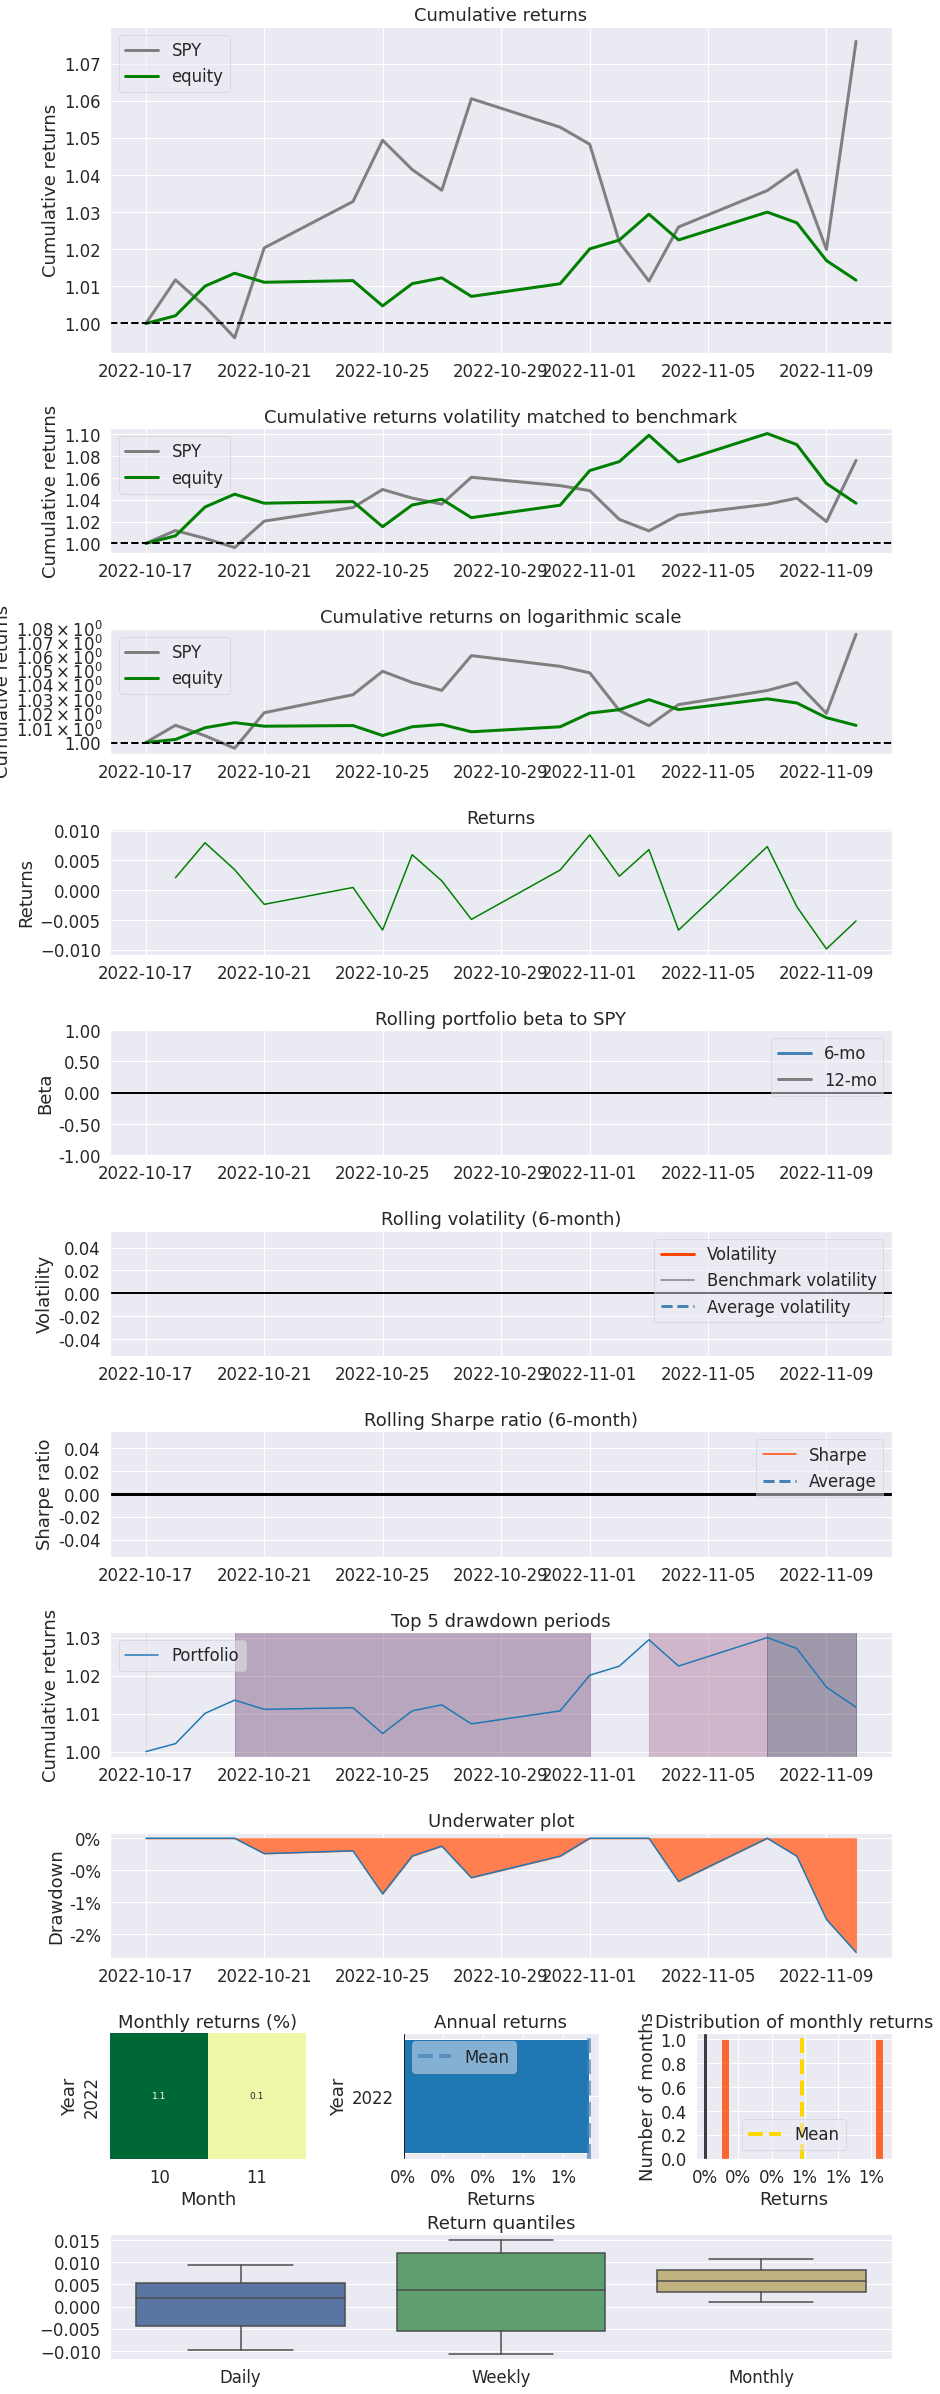

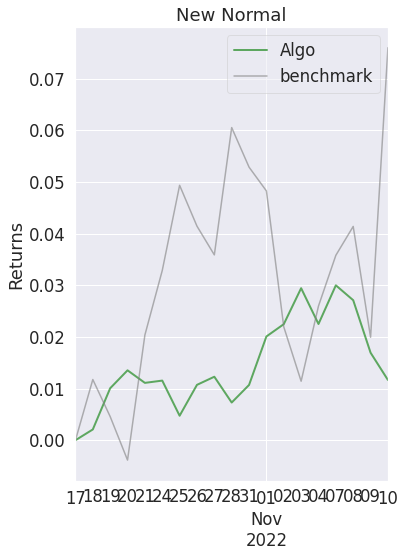

In [7]:
since = '2022-10-15'
df_pv = read_csv('portfolio_values.csv')
df_pv['Datetime'] = to_datetime(df_pv['Datetime'], format=YmdHMS_format)
df_pv['Datetime'] = df_pv['Datetime'].apply(lambda x: x.strftime(Ymd_format))
df_pv['Datetime'] = to_datetime(df_pv['Datetime'])
df_pv = df_pv.drop_duplicates(subset='Datetime', keep='last').sort_values(by='Datetime').set_index('Datetime')
df_pv = df_pv.loc[since:, :]

df_bm = read_csv('/Users/yueyuchen/Documents/Academy/Research/MarketWatch/data/daily/SPY.csv')
df_bm['Date'] = to_datetime(df_bm['Date'])
df_bm.set_index('Date', inplace=True)
df_bm = df_bm.loc[since:, :]
df_bm['SPY'] = df_bm['Adj Close'].pct_change()


pf.create_full_tear_sheet(
    df_pv['equity'].pct_change(), 
    benchmark_rets=df_bm['SPY'],
    test_path='/Users/yueyuchen/Documents/Academy/Research/PaperTrading/Results/SectorRFRank_10082022'
)


In [5]:
df_pv['equity'].pct_change()

Datetime
2022-10-17         NaN
2022-10-18    0.002085
2022-10-19    0.007958
2022-10-20    0.003436
2022-10-21   -0.002397
2022-10-24    0.000437
2022-10-25   -0.006726
2022-10-26    0.005950
2022-10-27    0.001555
2022-10-28   -0.004933
2022-10-31    0.003378
2022-11-01    0.009287
2022-11-02    0.002335
2022-11-03    0.006809
2022-11-04   -0.006732
2022-11-07    0.007330
Name: equity, dtype: float64